# Sensor Based Activity Recoginition 
Challenge: cdl1 - Sensor based Activity Recognition  
Team: Lea Bütler, Manjavy Kirupa, Etienne Roulet, Si Ben Tran  

Aufgabe: DL Modell erstellen

Hier in diesem Notebook erstellen wir unsere Deep Learning Modelle.

In [2]:
import tensorflow as tf
from sklearn.model_selection import KFold
import numpy as np
import logging
from datetime import datetime
import dataclasses
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn import model_selection as ms
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import os
from tensorflow.keras.callbacks import TensorBoard

tf.debugging.set_log_device_placement(False)

# datetime as filename for logging
now = datetime.now()
date_time_string = now.strftime("%Y-%m-%d_%H-%M-%S")

logging.basicConfig(level=logging.INFO, filename = f"{date_time_string}.txt", filemode='a')
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [3]:
%tensorboard --logdir logs

UsageError: Line magic function `%tensorboard` not found.


In [4]:
from dataclasses import dataclass
# Static Parameters
@dataclass
class Parameters():
    batch_size: int = 128
    epochs: int = 10
    verbosity: str = "auto"
    step_size: int = 374
    number_folds: int = 2
    output_size: int = 6

In [5]:
# read the CSV file into a DataFrame
df = pd.read_csv("Alle_Messungen_trimmed.csv") 
df.head(1)

,Unnamed: 0,time,Accelerometer_x,Accelerometer_y,Accelerometer_z,Gyroscope_x,Gyroscope_y,Gyroscope_z,Magnetometer_x,Magnetometer_y,Magnetometer_z,Orientation_qx,Orientation_qy,Orientation_qz,id,user,class,id_combined
0,1,2023-02-27 15:02:17.156,0.0,9.722,1.278,0.0,0.0,0.0,0.0,0.0,0.0,-0.21775,-0.719579,0.631111,01_SamsungA22-2023-02-27_15-02-03,Ben_Tran,Laufen,01_SamsungA22-2023-02-27_15-02-03Ben_TranLaufen


In [6]:
# convert the string time column to datetime
epoch = pd.Timestamp('1970-01-01')

df['time'] = pd.to_datetime(df['time'])
df['time'] = (df['time'] - epoch).apply(lambda x: int(x.total_seconds() * 1000))

In [7]:
# drop the columns that are not needed
df = df.drop(columns=["id", "user", "id_combined"])
df.drop(['Unnamed: 0'], axis=1, inplace=True)
# get all types of the df
#df['time'] = pd.to_datetime(df['time'])
#df['time'] = df['time'].astype('int64')//1e9
le = LabelEncoder()
df["class"] = le.fit_transform(df["class"])


In [8]:
# without rolling windows but with timesteps
X = df.values[:, 1:13]
y = df.values[:, 13]

# Reshape X to 3D format (samples, timesteps, features)
timesteps = 1  # You can choose a different number of timesteps based on the nature of your data
n_features = X.shape[1]
X = X.reshape(-1, timesteps, n_features)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert the labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=6)
y_test = to_categorical(y_test, num_classes=6)
# calculate_rolling_stats

In [9]:
from sklearn.model_selection import TimeSeriesSplit

# Set the window size and step size
window_size = 5
step_size = 1

# Reshape X to 2D format (samples, features)
X = df.values[:, 1:13]

# Define y
y = df["class"].values

# Create a sliding window of X with the specified window and step sizes
X_windows = np.array([X[i:i+window_size,:] for i in range(0,X.shape[0]-window_size+1,step_size)])

# Reshape X_windows to 3D format (samples, timesteps, features)
timesteps = X_windows.shape[1]
n_features = X_windows.shape[2]
X_windows = X_windows.reshape(-1, timesteps, n_features)

# Create the corresponding y labels for the sliding windows
y_windows = np.array([y[i+window_size-1] for i in range(0,X.shape[0]-window_size+1,step_size)])
y_windows = to_categorical(y_windows, num_classes=6)

# Create the time-series cross-validator
tscv = TimeSeriesSplit(n_splits=5)

# Split the dataset into training and testing sets using time-series cross-validation
for train_index, test_index in tscv.split(X_windows):
    X_train, X_test = X_windows[train_index], X_windows[test_index]
    y_train, y_test = y_windows[train_index], y_windows[test_index]


In [10]:

# Set the window size and step size
window_size = 5
step_size = 1

# Reshape X to 2D format (samples, features)
X = df.values[:, 1:13]

# Define y
y = df["class"].values

# Create a sliding window of X with the specified window and step sizes
X_windows = np.array([X[i:i+window_size,:] for i in range(0,X.shape[0]-window_size+1,step_size)])

# Reshape X_windows to 3D format (samples, timesteps, features)
timesteps = X_windows.shape[1]
n_features = X_windows.shape[2]
X_windows = X_windows.reshape(-1, timesteps, n_features)

# Create the corresponding y labels for the sliding windows
y_windows = np.array([y[i+window_size-1] for i in range(0,X.shape[0]-window_size+1,step_size)])
y_windows = to_categorical(y_windows, num_classes=6)

# Create the time-series cross-validator
tscv = TimeSeriesSplit(n_splits=5)

# Split the dataset into training and testing sets using time-series cross-validation
for train_index, test_index in tscv.split(X_windows):
    X_train, X_test = X_windows[train_index], X_windows[test_index]
    y_train, y_test = y_windows[train_index], y_windows[test_index]

In [11]:
# log it with logging
logging.info(f"X.shape: {X.shape}, y.shape: {y.shape}, X_train.shape: {X_train.shape}, y_train.shape: {y_train.shape}, X_test.shape: {X_test.shape}, y_test.shape: {y_test.shape}")

In [15]:
# Something like this as first Model
def create_model_1():
    model = tf.keras.Sequential([
        # Add a 1D convolutional layer
        tf.keras.layers.Conv1D(filters=128, kernel_size=2, activation='relu', padding='same', input_shape=(timesteps, n_features)),
        
        tf.keras.layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2),
        tf.keras.layers.Dropout(0.2),

        # Add a dense output layer
        tf.keras.layers.Dense(6, activation='softmax')  # Change activation function based on the nature of the output
    ])
    model.compile(optimizer='adam',   loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])  # Change the loss function based on the nature of the output
    return model


# Something like this as second Model
def create_model_2():
    model = tf.keras.Sequential([
        # Add a 1D convolutional layer
        tf.keras.layers.Conv1D(filters=256, kernel_size=2, activation='relu', padding='same', input_shape=(timesteps, n_features)),
        
        # Add LSTM layer
        tf.keras.layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2),
        tf.keras.layers.Dropout(0.2),

        # Add a dense output layer
        tf.keras.layers.Dense(6, activation='softmax')  # Change activation function based on the nature of the output
    ])
    model.compile(optimizer='adam',   loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])  # Change the loss function based on the nature of the output
    return model

# Something like this as Third Model
def create_model_3():
    model = tf.keras.Sequential([
        # Add a 1D convolutional layer
        tf.keras.layers.Conv1D(filters=64, kernel_size=4, activation='relu', padding='same', input_shape=(timesteps, n_features)),
        
        tf.keras.layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2),
        tf.keras.layers.Dropout(0.2),

        # Add a dense output layer
        tf.keras.layers.Dense(6, activation='softmax')  # Change activation function based on the nature of the output
    ])
    model.compile(optimizer='adam',   loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])  # Change the loss function based on the nature of the output
    return model

def create_model_4():
    model = tf.keras.Sequential([
        # Add a 1D convolutional layer
        tf.keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu', padding='same', input_shape=(timesteps, n_features)),
        
        tf.keras.layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2),
        tf.keras.layers.Dropout(0.2),

        # Add a dense output layer
        tf.keras.layers.Dense(6, activation='softmax')  # Change activation function based on the nature of the output
    ])
    model.compile(optimizer='adam',   loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])  # Change the loss function based on the nature of the output
    return model

In [16]:
# Create a function for training models with TensorBoard

x_train = X_train
x_test = X_test
y_train = y_train
y_test = y_test

def train_model_with_tensorboard(model_creator, train_x, train_y, test_x, test_y, model_name):
    log_dir = os.path.join("logs", model_name, datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

    model = model_creator()
    history = model.fit(
        train_x, train_y,
        epochs=Parameters.epochs,
        batch_size=Parameters.batch_size,
        validation_data=(test_x, test_y),
        verbose=Parameters.verbosity,
        callbacks=[tensorboard_callback]
    )
    
    return model, history

best_model_history = None  # Keep track of the best model's history
model_histories = []

# Perform cross-validation
models = [create_model_1,create_model_2,create_model_3,create_model_4]
best_model = None
num_folds = Parameters.number_folds
kfold = KFold(n_splits=num_folds, shuffle=True)
fold_acc_scores = []

for i, (train, test) in enumerate(kfold.split(x_train, y_train)):
    logging.info(f'Fold {i+1}')
    train_x, train_y = x_train[train], y_train[train]
    test_x, test_y = x_train[test], y_train[test]
    
    fold_histories = []

    for j, model_creator in enumerate(models):
        logging.info(f'Model {j+1}')
        model_name = f'fold_{i + 1}_model_{j + 1}'
        model, history = train_model_with_tensorboard(model_creator, train_x, train_y, test_x, test_y, model_name)

        test_loss, acc = model.evaluate(test_x, test_y, verbose=Parameters.verbosity)
        logging.info(f'Validation accuracy: {acc}')
        
        fold_histories.append(history.history)
        
        for epoch in range(Parameters.epochs):
            # Log accuracy after each epoch
            acc_epoch = history.history['val_accuracy'][epoch]
            logging.info(f'Epoch {epoch + 1}, Validation accuracy: {acc_epoch}')
        fold_acc_scores.append((i, j, acc))
        
        if best_model_history is None or acc > best_model_acc:
            best_model_history = history
            best_model = model
            best_model_acc = acc
    
    model_histories.append(fold_histories)

# Find the best model
best_model_index = np.argmax([score[2] for score in fold_acc_scores])
best_fold_idx, best_model_idx, _ = max(fold_acc_scores, key=lambda x: x[2])
best_model_history = model_histories[best_fold_idx][best_model_idx]

# Evaluate the best model on the test set
test_loss, test_acc = best_model.evaluate(x_test, y_test)
logging.info(f'Test accuracy {test_acc}')


Epoch 1/10
8130/8130 [==============================] - 157s 19ms/step - loss: 0.1532 - accuracy: 0.9474 - precision: 0.9549 - recall: 0.9407 - val_loss: 0.0903 - val_accuracy: 0.9698 - val_precision: 0.9725 - val_recall: 0.9673
Epoch 2/10
8130/8130 [==============================] - 156s 19ms/step - loss: 0.0714 - accuracy: 0.9758 - precision: 0.9773 - recall: 0.9744 - val_loss: 0.0673 - val_accuracy: 0.9774 - val_precision: 0.9787 - val_recall: 0.9763
Epoch 3/10
3251/8130 [==========>...................] - ETA: 1:15 - loss: 0.0566 - accuracy: 0.9809 - precision: 0.9819 - recall: 0.9800

KeyboardInterrupt: 

In [36]:
model_histories

[[{'loss': [0.25769704580307007,
    0.12571962177753448,
    0.09509823471307755,
    0.08032198250293732,
    0.07046161592006683,
    0.06395179033279419,
    0.059530019760131836,
    0.05598163977265358,
    0.05254220589995384,
    0.05009842664003372],
   'accuracy': [0.9110851883888245,
    0.9570886492729187,
    0.9674150943756104,
    0.9723440408706665,
    0.9757274985313416,
    0.9779247045516968,
    0.9794702529907227,
    0.9805443286895752,
    0.9815773963928223,
    0.9825904369354248],
   'val_loss': [0.15062780678272247,
    0.1104658767580986,
    0.09079216420650482,
    0.08003628253936768,
    0.07696308195590973,
    0.06884759664535522,
    0.06626738607883453,
    0.06896661967039108,
    0.06965992599725723,
    0.06295178085565567],
   'val_accuracy': [0.9485871195793152,
    0.9616633057594299,
    0.9687905311584473,
    0.9729247093200684,
    0.9743421077728271,
    0.9769898056983948,
    0.9779947996139526,
    0.9767765402793884,
    0.97637516260

In [79]:
# Manual Test with unseen Data Future it should be the webapp
# Yvo
# Uff its now worse than before

from scipy.stats import mode
df_yvo = pd.read_csv("Yvo_Messung_Velo.csv")
df_yvo = df_yvo.drop(columns=["id", "user", "id_combined"])
df_yvo.drop(['Unnamed: 0'], axis=1, inplace=True)
epoch = pd.Timestamp('1970-01-01')
df_yvo['time'] = pd.to_datetime(df['time'])
df_yvo['time'] = (df_yvo['time'] - epoch).apply(lambda x: int(x.total_seconds() * 1000))
# get all types of the df
X = df_yvo.values[:, 1:13]
window_size = 10
step_size = 1
# Create a sliding window of X with the specified window and step sizes
X_windows = np.array([X[i:i+window_size,:] for i in range(0,X.shape[0]-window_size+1,step_size)])
# Reshape X_windows to 3D format (samples, timesteps, features)
timesteps = X_windows.shape[1]
n_features = X_windows.shape[2]
X_windows = X_windows.reshape(-1, timesteps, n_features)
X_windows = X_windows.astype('float32')
# Create the corresponding y labels for the sliding windows
# Get the predicted class probabilities for each input window
y_pred_probs = best_model.predict(X_windows)
print(y_pred_probs)
# Get the predicted class labels for each input window
y_pred_labels = np.argmax(y_pred_probs, axis=1)
# instead of the median print the most frequent label

class_counts = np.bincount(y_pred_labels)
for i, count in enumerate(class_counts):
    print(f"Class {i} count: {count}")



1953/1953 [==============================] - 7s 4ms/step
[[7.87351624e-08 1.62944488e-07 3.07707851e-05 4.34411095e-06
  1.08637471e-06 9.99963522e-01]
 [8.21598292e-08 6.02295742e-08 4.39178766e-05 2.52636642e-06
  4.78698439e-07 9.99952912e-01]
 [7.60544552e-08 3.07119024e-08 3.68612309e-05 1.96513633e-06
  2.36935009e-07 9.99960780e-01]
 ...
 [1.13503158e-03 6.44940941e-04 1.39978705e-02 9.83879089e-01
  6.95186027e-05 2.73550308e-04]
 [1.65032444e-03 2.18125992e-03 2.93452647e-02 9.66126204e-01
  1.12664340e-04 5.84299851e-04]
 [6.74462644e-03 8.30822531e-03 1.32167328e-03 9.74555254e-01
  5.07745659e-04 8.56247451e-03]]
Class 0 count: 15745
Class 1 count: 1034
Class 2 count: 879
Class 3 count: 4313
Class 4 count: 17637
Class 5 count: 22884


[0.25769704580307007, 0.12571962177753448, 0.09509823471307755, 0.08032198250293732, 0.07046161592006683, 0.06395179033279419, 0.059530019760131836, 0.05598163977265358, 0.05254220589995384, 0.05009842664003372]


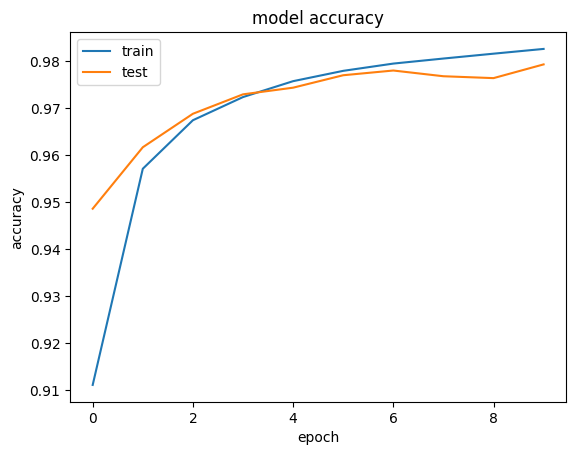

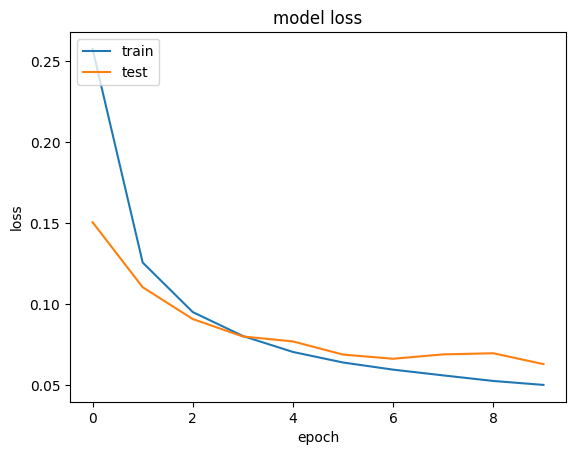

In [80]:
# visualize the training process
import matplotlib.pyplot as plt
import numpy as np

print(best_model_history['loss'])
# summarize history for accuracy
plt.plot(best_model_history['accuracy'])
plt.plot(best_model_history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(best_model_history['loss'])
plt.plot(best_model_history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [43]:
# summarise best model
best_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 5, 64)             1600      
                                                                 
 lstm_8 (LSTM)               (None, 100)               66000     
                                                                 
 dense_8 (Dense)             (None, 6)                 606       
                                                                 
Total params: 68,206
Trainable params: 68,206
Non-trainable params: 0
_________________________________________________________________


In [44]:
y_pred = model.predict(X_test)

15610/15610 [==============================] - 35s 2ms/step


In [ ]:
model.evaluate(X_test, y_test)

15610/15610 [==============================] - 39s 2ms/step


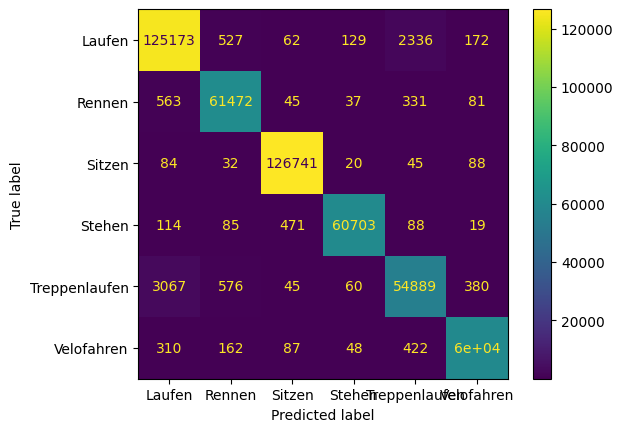

array([0.97142525, 0.9805476 , 0.99615265, 0.9912555 , 0.93724814,
       0.98548012])

In [46]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
#for multiclass classification
y_pred = best_model.predict(x_test)
y_test_labels = y_test.argmax(axis=1)
y_pred_labels = y_pred.argmax(axis=1)

cm = confusion_matrix(y_test_labels, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
# get f1 score of each class
from sklearn.metrics import f1_score
f1 = f1_score(y_test_labels, y_pred_labels, average=None)
# get f1 score of each class

disp.plot()
plt.show()
display(f1)

In [ ]:
# Create a Baseline Model

In [ ]:
# Compare Baseline vs best_model

In [ ]:
# plot graph for learning curve and loss curve from baseline and best_model

In [ ]:
# print loss and accuracy for best model over epoch and steps plot

In [ ]:
# Export Model for using in tensorflow.js
!mkdir -p saved_model
best_model.save('saved_model/sensor_model')
best_model.save('saved_model/sensor_model.h5')

In [ ]:
# Save the weight for the Js Model
best_model.save_weights('./checkpoints/my_checkpoint')


In [ ]:
# upload model to server to download it on tensorflow js

In [ ]:
dill.dump_session('notebook_env.db')